<a href="https://colab.research.google.com/github/taslimmuhammed/pytorch/blob/main/pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12134589.65it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205978.76it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3604709.56it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22168662.21it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
classes = train_data.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Text(0.5, 1.0, '9')

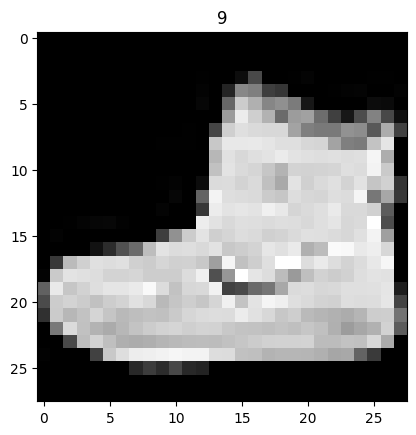

In [6]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)

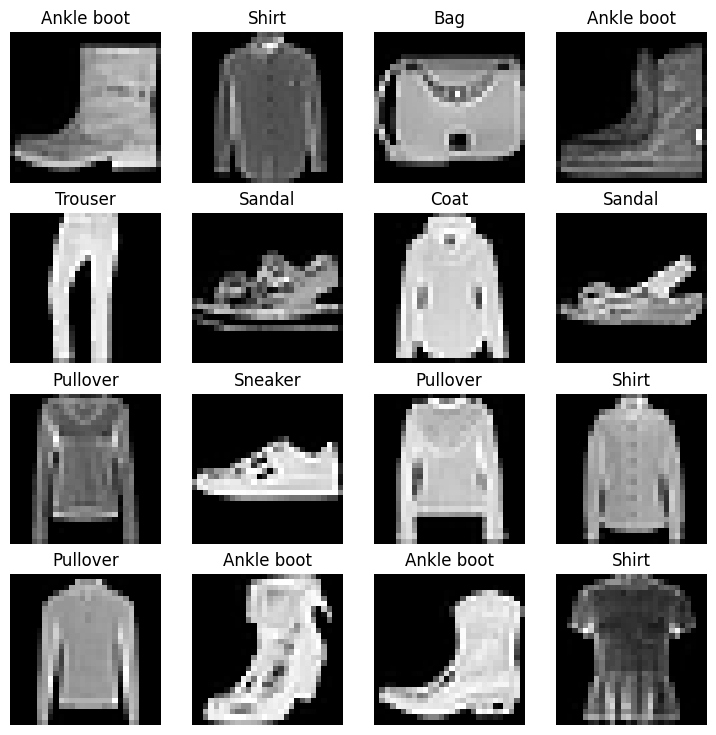

In [7]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(classes[label])
  plt.axis(False)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
def train_step(
    model:torch.nn.Module,
    data_loader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    optimizer:torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device):
  train_loss, train_acc = 0,0
  model.to(device)
  model.train()
  for batch , (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss +=loss.item()
    train_acc += accuracy_fn(y_true=y.cpu(), y_pred=y_pred.argmax(dim=1).cpu())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")


def test_step(
    model:torch.nn.Module,
    data_loader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    accuracy_fn,
    device: torch.device = device):
  test_loss, test_acc = 0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      test_loss += loss_fn(y_pred, y).item()
      test_acc += accuracy_fn(y_true=y.cpu(), y_pred=y_pred.argmax(dim=1).cpu())
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")



In [10]:
from timeit import default_timer as timer

In [11]:
class FashionMNISTModel(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3,1,1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3,1,1),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )

  def forward(self,X:torch.Tensor):
    X = self.block_1(X)
    X = self.block_2(X)
    X = self.classifier(X)
    return X

torch.manual_seed(42)
model_1 = FashionMNISTModel(input_shape=1, hidden_units=10, output_shape=len(classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
model_1

FashionMNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Calculating the Dimension of output of CNN and Pooling Layers

In [12]:
x = image.to(device)
x.shape

torch.Size([1, 28, 28])

In [13]:
x = model_1.block_1(x)
x.shape

torch.Size([10, 14, 14])

In [14]:
x = model_1.block_2(x)
x.shape

torch.Size([10, 7, 7])

* 10 is the number of CNN nodes/neurons in each layer
* 7*7 is the output shape, which we used above in the classifier layer

# Data Loader

In [15]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x79d6f544fbb0>, <torch.utils.data.dataloader.DataLoader object at 0x79d6f544f5e0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [16]:
from tqdm.auto import tqdm # for showing the range
from sklearn.metrics import accuracy_score
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")
  train_step(model=model_1,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_score,
            device=device)
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_score,
            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.51122 | Train acc: 0.82%
Test loss: 0.37079 | Test acc: 0.86%
Epoch: 1
Train loss: 0.33604 | Train acc: 0.88%
Test loss: 0.35153 | Test acc: 0.87%
Epoch: 2
Train loss: 0.30028 | Train acc: 0.89%
Test loss: 0.30618 | Test acc: 0.89%


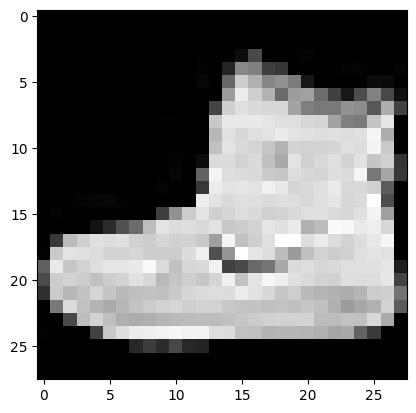

In [17]:
plt.imshow(image.squeeze(), cmap="gray")

In [18]:
with torch.inference_mode():
  logits = model_1(image.unsqueeze(dim=0).to(device))
logits

tensor([[-3.8030, -3.5349, -6.3808, -3.2814, -3.5556,  2.2335,  1.2868,  4.6303,
          0.9611, 10.0968]], device='cuda:0')

In [19]:
classes[torch.argmax(logits)]

'Ankle boot'

In [20]:
import random

test_sample = []
test_label = []
for img,label in random.sample(list(test_data),k=9):
  test_sample.append(img)
  test_label.append(label)

test_label

[4, 2, 3, 4, 6, 8, 6, 4, 4]

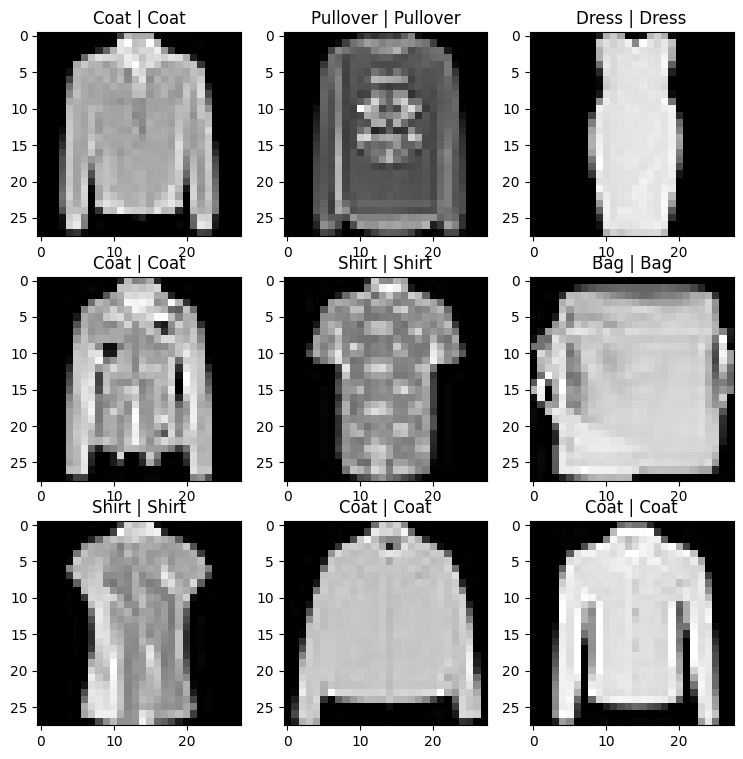

In [22]:
plt.figure(figsize=(9,9))
for i in range(9):
  plt.subplot(3,3,i+1)
  pred = classes[torch.argmax(model_1(test_sample[i].unsqueeze(dim=0).to(device)))]
  plt.imshow(test_sample[i].squeeze(),cmap="gray")
  plt.title(classes[test_label[i]]+" | "+pred)
